In [1]:
import cv2
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from src import kitti, stereo

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
dataset = kitti.KittiDataset(Path('dataset/sequences/00'))
ster = stereo.SGBMStereo(dataset.calib)

In [149]:
pcd = o3d.io.read_point_cloud("full-600-800no-mask.pcd")

In [147]:
pcd = o3d.io.read_point_cloud("full-600-800mask.pcd")

In [151]:
o3d.visualization.draw_geometries([pcd])

(-0.5, 1240.5, 375.5, -0.5)

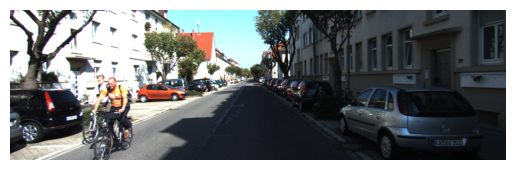

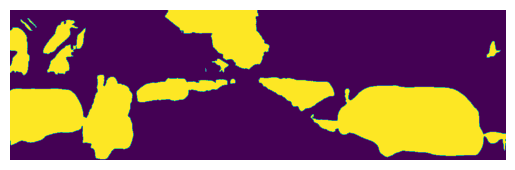

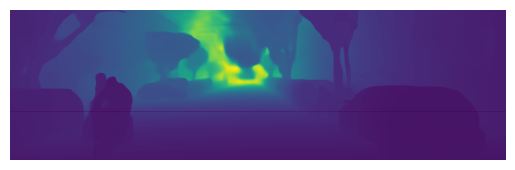

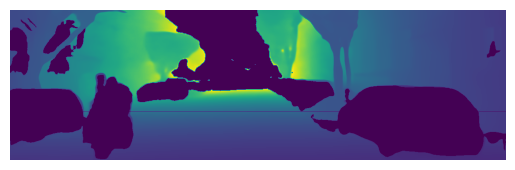

In [5]:
index = 654
mask = np.load("masks/mask%d.npy" % index).astype(np.bool8)
depth = np.load("depth/depth%d.npy" % index).astype(np.float32)
plt.figure(1)
left = cv2.imread("left/000%d.png" % index)
plt.imshow(left)
plt.axis('off')

plt.figure(2)
plt.imshow(mask)
plt.axis('off')

plt.figure(3)
plt.imshow(depth)
plt.axis('off')

plt.figure(4)
depth[mask] = 0
depth[depth > 0.45 * depth.max()] = 0
plt.imshow(depth)
plt.axis('off')

In [42]:
def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

In [43]:
frame = kitti.KittiFrame(dataset, 645)
pcd = ster.point_cloud(frame, depth)
pcd = pcd.voxel_down_sample(0.00009)

cl, ind = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
pcd = pcd.select_by_index(ind)
pcd.estimate_normals()
o3d.visualization.draw_geometries([pcd])

In [97]:
deltas_no_mask = np.load("full-600-800no-mask.odom")
deltas_mask = np.load("full-600-800mask.odom")

In [142]:
def compute_traj(deltas):
    T_tot = np.identity(4)

    trajectory = np.zeros((len(deltas), 3, 4))
    trajectory[0] = T_tot[:3, :]

    for i in range(1, len(deltas)):
        T_frame = deltas[i]
        T_tot = T_tot.dot(np.linalg.inv(T_frame))
        trajectory[i, :, :] = T_tot[:3, :]
    return trajectory

In [143]:
trajectory_mask = compute_traj(deltas_mask)
trajectory_no_mask = compute_traj(deltas_no_mask)

Text(0.5, 0, 'z')

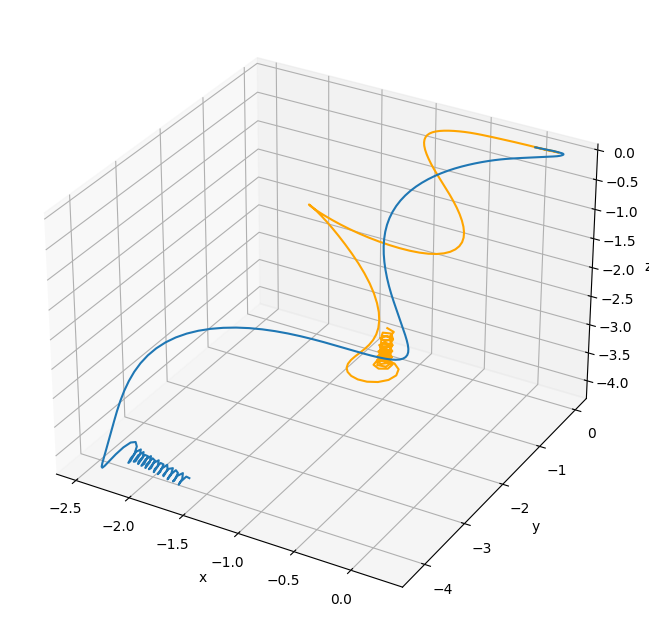

In [144]:

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
# ax = fig.add_subplot(111)

ax.plot(trajectory_mask[:, :, 3][:, 2], 
        trajectory_mask[:, :, 3][:, 1],
        trajectory_mask[:, :, 3][:, 1],
        color='orange', label='Mask')

ax.plot(trajectory_no_mask[:, :, 3][:, 2], 
        trajectory_no_mask[:, :, 3][:, 1],
        trajectory_no_mask[:, :, 3][:, 1],
        label='No Mask')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')